In [64]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np 
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [65]:
# checking for GPU availability
from keras import backend as K
print(tf.config.list_physical_devices('GPU')) # check if it's installed using gpu
print(tf.test.gpu_device_name()) # check the same
# print(K._get_available_gpus())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import sys

# print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {keras.__version__}")
# print()
# print(f"Python {sys.version}")
# gpu = len(tf.config.list_physical_devices('GPU'))>0
# print("GPU is", "available" if gpu else "NOT AVAILABLE")

[]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4445018063701183923
xla_global_id: -1
]


In [66]:
kernel_sizes = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
dropouts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
num_filters = [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 
               35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 
               45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
               55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
kernel_initializers = ['he_normal', 'random_normal']
pooling = ['median', 'max']
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
padding = ['causal', 'same', 'valid']
optimizers = ['Adamax', 'Adam', 'RMSprop']

In [97]:
hyperparams = {'kernel_size':kernel_sizes, 'dropout':dropouts, 'num_filters':num_filters, 
               'kernel_initializer':kernel_initializers,  'learning_rates':learning_rates,
               'padding':padding, 'optimizers':optimizers
              }#'pooling':pooling,

In [68]:
window_size=500

In [69]:
# # prep functions for input into model
def fill_time(time):
    """
    This snippet was taken almost directly from lightkurve fill_gaps source code
    Takes an array of times, finds any gaps and returns a gapless time array
    
    Parameters
    ----------
    time : array
        Array times to fill gaps within
        
    Returns
    -------
    ntime : array
        Array of times with gaps filled
    """
    dt = np.nanmedian(time[1::] - time[:-1:])
    ntime = [time[0]]
    for t in time[1::]:
        prevtime = ntime[-1]
        while (t - prevtime) > 1.2 * dt: # why 1.2?
            ntime.append(prevtime + dt)
            prevtime = ntime[-1]
        ntime.append(t)
    return np.asarray(ntime, float)


def fill_gaps(time, ntime, attr, zeros=False):
    """
    Adapted from lightkurve fill_gaps source code
    This is kind of janky, could just have a wrapper for fill_time 
    where if attr is none than we just fill time
    and if attr is an actual array we fill time and the gaps in the attribute
    the only thing is it's repetitively calling fill_time 
    whereas now it just takes an output from fill_time every time it's called
    
    Parameters
    ----------
    time : array
        Original array of times without gaps filled in
    ntime : array
        Filled array of times
    attr : array
        Original array of some values defined at `time` times
        
        
    Returns
    -------
    nattr : array
        Array of values with length ntime
    """
    in_original = np.in1d(ntime, time)
    nattr = np.zeros(len(ntime)) # initialize new attribute array
    nattr[in_original] = np.copy(attr) # copy input array
    if zeros == False:
        nattr[~in_original] = np.interp(ntime[~in_original], time, attr)
    else:
        nattr[~in_original] = 0
    return nattr


def pad(attr, window_size=window_size, zeros=False):
    """
    Parameters
    ----------
    attr : array
        Array to pad
    window_size : int
        Total number of points to pad attr by,
        with window_size // 2 points on each end
    zeros : bool
        Pad with zeros if True. 
        Default is to pad with the first and last values of attr
        
    Returns
    -------
         : array
        Padded array of values
    """
    if zeros == False:
        attr_left = np.full((window_size//2,), attr[0])
        attr_right = np.full((window_size//2,), attr[-1])
        return np.hstack([attr_left, attr, attr_right])
    elif zeros == True:
        padding = np.full((window_size//2,), 0)
        return np.hstack([padding, attr, padding])
    else:
        return ValueError("That is not a valid entry for the `zeros` parameter. Please enter True or False")


In [70]:
def prep_for_generator(target_data, fname=None, window_size=window_size):
    flux_list = []
    label_list = []
    centroid_list = []
    poscorr_list = []
    cr_list = []
    # print('loading in data')
    #for file in fnames:
    # print(file)
    #target_data = np.load(file, allow_pickle=True).T
    #     data=[self.lc_time, self.lc.flux.value, self.lc.flux_err.value, self.lc.quality.value, self.pos_corr, self.c_dist, self.crArr]
    lc_time = target_data[0]
    lc_flux = target_data[-1] # injected flux array
    
#       lc_ferr = target_data[2] # flux error
    lc_quality = target_data[3] # quality
    lc_poscorr = target_data[4] # pos corr
    lc_cdist = target_data[5] # magnitude of centroid shift
    lc_crArr = target_data[6] # cosmic ray array
    lc_flareArr = target_data[-2] # flare array
    lc_flux = np.nan_to_num(lc_flux, np.nanmedian(lc_flux))
    lc_poscorr = np.nan_to_num(lc_poscorr, 0)
    lc_cdist = np.nan_to_num(lc_cdist, 0)
    lc_crArr = np.nan_to_num(lc_crArr, 0)
    lc_flareArr = np.nan_to_num(lc_flareArr, 0)
#     plt.plot(lc_time[:5000], lc_flux[:5000])
#     plt.plot(lc_time[:1000], lc_poscorr[:1000])
#     plt.plot(lc_time[:1000], lc_cdist[:1000])
#     plt.plot(lc_time[:5000], lc_flareArr[:5000])
#     plt.show()
#         print(lc_flux)
    # print('getting nan indices')
    # nan_indices = np.where(np.isnan(lc_time) | np.isnan(lc_flux) | np.isnan(lc_quality) | np.isnan(lc_poscorr) | np.isnan(lc_cdist) | np.isnan(lc_crArr) | np.isnan(lc_flareArr) )[0]
    # # # print(nan_indices)
    # # a=100
    # # k=200
    # # plt.plot(lc_time[:k], np.nan_to_num(lc_flux[:k], nan=0))
    # # plt.plot(lc_time[:k]+1, lc_flux[:k]+1)
    # # plt.plot(lc_time[:k], np.full(k,0))
    # print('getting rid of nans')
    # lc_time = lc_time[~nan_indices]
    # lc_flux = lc_flux[~nan_indices]
    # lc_quality = lc_quality[~nan_indices]
    # lc_poscorr = lc_poscorr[~nan_indices]
    # lc_cdist = lc_cdist[~nan_indices]
    # lc_crArr = lc_crArr[~nan_indices]
    # lc_flareArr= lc_flareArr[~nan_indices]

    # print('filling gaps')
    # fill gaps
    ntime = fill_time(lc_time)
    nflux = fill_gaps(lc_time, ntime, lc_flux)
    ncentroid = fill_gaps(lc_time, ntime, lc_cdist)
    nposcorr = fill_gaps(lc_time, ntime, lc_poscorr)
    ncr = fill_gaps(lc_time, ntime, lc_crArr)
#         print('orig num of flare pts', len(flareArr[flareArr==1]), 'out of a total of', len(flareArr))
    labels = fill_gaps(lc_time, ntime, lc_flareArr, zeros=True)
#         print('filled num fluxes', len(nflux))
#         print('filled num labels', len(labels))

    # print('padding')
    # pad the LC
    nflux = pad(nflux, window_size=window_size)
    labels = pad(labels, window_size=window_size, zeros=True)
    ncentroid = pad(ncentroid, window_size=window_size)
    nposcorr = pad(nposcorr, window_size=window_size)
    ncr = pad(ncr, window_size=window_size, zeros=True)

#         fig, ax = plt.subplots(2, sharex=True)
#         ax[0].plot(nflux[-100:])
#         ax[1].plot(labels[-100:])
   
    if fname is not None:
        root = str(fname).split('/')
        root = root[-1]
        df = pd.DataFrame(data=[ntime, nflux, nposcorr, ncentroid, ncr, labels]).T
        np.save('filled_padded_data/'+root, np.asarray(df))

    # print('LENGTHS', len(labels), len(nflux))
    label_list.append(labels)
    flux_list.append(nflux)
    centroid_list.append(ncentroid)
    poscorr_list.append(nposcorr)
    cr_list.append(ncr)
#         print(len(label_list))
#         print(len(flux_list))
#     print('plotting')
#     plt.figure(figsize=(10, 8))
#     k = 500
#     plotflux = nflux[440:k]
#     plottime = ntime[440:k]
#     plt.plot(plottime, plotflux, color='black')
# #         print('final num of flare pts', len(labels[labels==1]))
# #         print('final num of nonflare pts', len(labels[labels==0]))
#     plt.plot(plottime[labels[440:k]==1], plotflux[labels[440:k]==1], color='red', marker='o', ls='none', markersize=2)
#     plt.show()
    print(' fluxes', len(flux_list), 'labels', len(label_list), 'centroid', len(centroid_list), 'poscorr', len(poscorr_list))
#     print(flux_list, label_list, centroid_list, poscorr_list, cr_list)
    return flux_list, label_list, centroid_list, poscorr_list, cr_list


In [ ]:
fname = 'training_data/29830830_35_1_data.npy'
# fname = 'training_data/138471905_59_1_data.npy'
# fname = 'training_data/138471905_59_1_data.npy'

# fname = '/Users/veraberger/nasa/training_data/257004995_47_1_data.npy'
x = np.load(fname).T
t=x[0]
ntime = fill_time(t)
ntime = pad(ntime)

# plt.plot(x[0][:1000], x[-1][:1000])

k = 3000
# print(x[0].min(), ntime.min())

# np.any(np.isnan(x[1]))
flux_list, label_list, centroid_list, poscorr_list, cr_list = prep_for_generator(x)
# print(len(flux_list))

# np.any(np.isnan(flux_list))


plt.plot(x[0][:k], x[-1][:k]+.5, label='orig')
plt.plot(ntime[:k], np.asarray(flux_list).flatten()[:k], label='filled padded')
plt.legend()
plt.show()

# if the filled padded one looks shorter its because we are plotting the same number of pts for each so more pts are 
# going into what was simply undefined in the original lc

In [71]:
import math
def multiple_training_data_generator(file_list, batch_size=32, window_size=window_size, drop_frac=0.5,  train=True):
    for file in file_list:
        print(file)
        target_data = np.load(file, allow_pickle=True).T
        lc_list, label_list, centroid_list, poscorr_list, cr_list = prep_for_generator(target_data, file)
        i = 0
        # print('length of lc list', len(lc_list))
        while i < len(lc_list):
            target_lc = lc_list[i]
            centroid_lc = centroid_list[i]
            poscorr_lc = poscorr_list[i]
            cr_lc = cr_list[i]
            labels = label_list[i] # flare array

            lc_length = len(target_lc)
            valid_indices = np.arange(int(window_size/2), int(lc_length-window_size/2), dtype=int) 
            
            # choose indices randomly to include in the batches
            if train:
                # valid_indices = np.random.choice(valid_indices, size=round(len(valid_indices)*drop_frac), replace=False)
                valid_lc = target_lc[valid_indices]
                valid_labels = labels[valid_indices]
                flare_indices = valid_indices[valid_labels==1]
                nonflare_indices = valid_indices[valid_labels==0]
                size =  min(len(nonflare_indices), len(flare_indices))
                # include many/all CR points in nonflare set to not lose cr info
                # even flare and notflare&cr

                valid_flare_indices = np.random.choice(flare_indices, size=math.floor(size*drop_frac), replace=False)
                valid_nonflare_indices = np.random.choice(nonflare_indices, size=math.floor(size*drop_frac), replace=False)
                valid_indices = np.concatenate((valid_flare_indices, valid_nonflare_indices))
                
                np.random.shuffle(valid_indices)
                # print(valid_indices)
                # plt.figure(figsize=(10,8))
                # plt.plot(range(len(target_lc)), target_lc)
                # plt.plot(valid_flare_indices, target_lc[valid_flare_indices], ls='none', marker='o', c='g')
                # plt.plot(valid_nonflare_indices, target_lc[valid_nonflare_indices], ls='none', marker='o', c='r')
                # plt.show()
                
            else:
                raise NotImplementedError
            j = 0 #J loops through the time series for a single target
            # print(valid_indices)
            # print(len(valid_indices))
            
            while j+batch_size <= len(valid_indices):
                data = np.empty((batch_size, window_size, 1)) # lc
                data_centroid = np.empty((batch_size, window_size, 1)) # centroid
                data_poscorr = np.empty((batch_size, window_size, 1)) # poscorr
                data_cr = np.empty((batch_size, window_size, 1)) # crs
                label = np.empty((batch_size), dtype=int)
                # generate a batch
                for k in range(batch_size):

#                     make an lc centered at valid_indices[j+k] of length window_size
                    X = target_lc[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)].reshape(window_size,1)
                    data[k,] = RobustScaler().fit_transform(X)
                    label[k] = np.asarray(labels[valid_indices[j+k]]) # marks whether or not the point at j+k is part of a flare
                    X2 = centroid_lc[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)].reshape(window_size,1)
                    data_centroid[k,] = RobustScaler().fit_transform(X2)
                    X3 = poscorr_lc[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)].reshape(window_size,1)
                    data_poscorr[k,] = RobustScaler().fit_transform(X3)
                    X4 = cr_lc[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)].reshape(window_size,1)
                    data_cr[k,] = RobustScaler().fit_transform(X4)

#                     plt.plot(data[k], color='black')
# #                         plt.plot(data_poscorr[k]-3, color='c')
# #                         plt.plot(data_centroid[k]+5, color='g')
# #                         plt.plot(data_cr[k], color='y')
#                     # plt.axvline(window_size/2, color='black')
#                     plt.plot(label[k], c='r')
#                     plt.title(label[k])
# #                         print('label[k]', label[k])
#                     plt.plot(labels[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)], c='r')
#                     plt.ylim(-2,20)
#                     plt.show()

                # print(label)
                yield {"inputA":data, "inputB":data_centroid, "inputC":data_poscorr, "inputD":data_cr}, label
                j = j + batch_size
            i = i + 1

In [73]:
import glob
file_list = glob.glob('/home/jovyan/flarenetnot/src/flarenet/training_data/*')
len(file_list)

690

In [74]:
test_data = multiple_training_data_generator(file_list, batch_size=32, window_size=window_size)
test_data

<generator object multiple_training_data_generator at 0x7feee67a9350>

In [75]:
num = 0

for data, label in test_data:
    print(data['inputA'].shape, data['inputB'].shape, data['inputC'].shape, data['inputD'].shape, label.shape)
    print(label, "<--Labels")
    print()
    num = num + 1
    if num > 5: break

/home/jovyan/flarenetnot/src/flarenet/training_data/25078597_34_2_data.npy
 fluxes 1 labels 1 centroid 1 poscorr 1
(32, 500, 1) (32, 500, 1) (32, 500, 1) (32, 500, 1) (32,)
[1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1] <--Labels

(32, 500, 1) (32, 500, 1) (32, 500, 1) (32, 500, 1) (32,)
[1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0] <--Labels

(32, 500, 1) (32, 500, 1) (32, 500, 1) (32, 500, 1) (32,)
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1] <--Labels

(32, 500, 1) (32, 500, 1) (32, 500, 1) (32, 500, 1) (32,)
[0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1] <--Labels

(32, 500, 1) (32, 500, 1) (32, 500, 1) (32, 500, 1) (32,)
[1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1] <--Labels

(32, 500, 1) (32, 500, 1) (32, 500, 1) (32, 500, 1) (32,)
[1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0] <--Labels



In [76]:
# Define a basic ML that we can use to make sure we know the data is being imported correctly
def basic_model():
    
    # There is 1 input light curve. In this case, we're just looking at the flux 1D time series
    inputA = keras.layers.Input(shape=(window_size,1), name='inputA') # flux lc
    inputB = keras.layers.Input(shape=(window_size,1), name='inputB') # centroid
    inputC = keras.layers.Input(shape=(window_size,1), name='inputC') # pos corr
    inputD = keras.layers.Input(shape=(window_size,1), name='inputD') # cosmic rays

    # Convolutions on the flux lightcurve
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputA)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)
    # A = keras.layers.BatchNormalization()(A) # check on if these just need to be at the end
    # 2
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 3
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 4
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 5
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)   
    # A = keras.layers.BatchNormalization()(A)
    # 6
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 7
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 8
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 9
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)  
    # A = keras.layers.BatchNormalization()(A)
    # 10
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='same')(A)
    A = keras.layers.Dropout(0.2)(A)  
    # A = keras.layers.BatchNormalization()(A)

    A = keras.layers.Flatten()(A)
    A = keras.models.Model(inputA, A)

    # centroid 
    B = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputB)
    B = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(B)
    B = keras.layers.MaxPooling1D(pool_size=3, strides=2)(B)
    B = keras.layers.Dropout(0.2)(B)
    
    B = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(B)
    B = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(B)
    B = keras.layers.MaxPooling1D(pool_size=3, strides=2)(B)
    B = keras.layers.Dropout(0.2)(B)
    B = keras.layers.Flatten()(B)
    B = keras.models.Model(inputB, B)

    # pos corr
    C = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputC)
    C = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(C)
    C = keras.layers.MaxPooling1D(pool_size=3, strides=2)(C)
    C = keras.layers.Dropout(0.2)(C)
    
    C = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(C)
    C = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(C)
    C = keras.layers.MaxPooling1D(pool_size=3, strides=2)(C)
    C = keras.layers.Dropout(0.2)(C)
    C = keras.layers.Flatten()(C)
    C = keras.models.Model(inputC, C)

    # cosmic rays
    D = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputD)
    D = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(D)
    D = keras.layers.MaxPooling1D(pool_size=3, strides=2)(D)
    D = keras.layers.Dropout(0.2)(D)
    
    D = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputD)
    D = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(D)
    D = keras.layers.MaxPooling1D(pool_size=3, strides=2)(D)
    D = keras.layers.Dropout(0.2)(D)
    D = keras.layers.Flatten()(D)
    D = keras.models.Model(inputD, D)

    # Combine the two convolution branches before entering the dense neural network layers
    combined = keras.layers.concatenate([A.output, B.output, C.output, D.output])
#     combined=A.output

    # Final fully connected layers to make the prediction
    # Note that the final layer has an output shape of 1. This is because it will be a single prediction between 0 and 1
    F = keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(combined) # look at size of input to this layer, if smaller than 512 maybe make 512 smaller. look at what stella does too
    F = keras.layers.Dropout(0.2)(F)
    F = keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(F)
    F = keras.layers.Dropout(0.2)(F)
    F = keras.layers.Dense(1, activation='sigmoid')(F)
    # keep the relu -> sigmoid


    multi_layer_model = keras.models.Model(inputs=(inputA, inputB, inputC, inputD), outputs=(F))

    multi_layer_model.compile(
    optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    )
    return multi_layer_model

In [98]:
# Define a basic ML that we can use to make sure we know the data is being imported correctly
"""hyperparams = {'kernel_size':kernel_sizes, 'dropout':dropouts, 'num_filters':num_filters, 
               'kernel_initializer':kernel_initializers, 'pooling':pooling, 'learning_rates':learning_rates,
               'padding':padding, 'optimizers':optimizers
              }"""
def gridsearch_model():
    # can add params to dict that are specific to each input 
    
    # There is 1 input light curve. In this case, we're just looking at the flux 1D time series
    inputA = keras.layers.Input(shape=(window_size,1), name='inputA') # flux lc
    inputB = keras.layers.Input(shape=(window_size,1), name='inputB') # centroid
    inputC = keras.layers.Input(shape=(window_size,1), name='inputC') # pos corr
    inputD = keras.layers.Input(shape=(window_size,1), name='inputD') # cosmic rays

    # Convolutions on the flux lightcurve
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(inputA)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)
    # A = keras.layers.BatchNormalization()(A) # check on if these just need to be at the end
    # 2
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 3
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 4
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 5
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)   
    # A = keras.layers.BatchNormalization()(A)
    # 6
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 7
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2,padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 8
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)
    # A = keras.layers.BatchNormalization()(A)
    # 9
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)  
    # A = keras.layers.BatchNormalization()(A)
    # 10
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='same')(A)
    A = keras.layers.Dropout(dropout)(A)  
    # A = keras.layers.BatchNormalization()(A)

    A = keras.layers.Flatten()(A)
    A = keras.models.Model(inputA, A)

    # centroid 
    B = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(inputB)
    B = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(B)
    B = keras.layers.MaxPooling1D(pool_size=3, strides=2)(B)
    B = keras.layers.Dropout(dropout)(B)
    
    B = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(B)
    B = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(B)
    B = keras.layers.MaxPooling1D(pool_size=3, strides=2)(B)
    B = keras.layers.Dropout(dropout)(B)
    B = keras.layers.Flatten()(B)
    B = keras.models.Model(inputB, B)

    # pos corr
    C = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(inputC)
    C = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(C)
    C = keras.layers.MaxPooling1D(pool_size=3, strides=2)(C)
    C = keras.layers.Dropout(dropout)(C)
    
    C = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(C)
    C = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(C)
    C = keras.layers.MaxPooling1D(pool_size=3, strides=2)(C)
    C = keras.layers.Dropout(dropout)(C)
    C = keras.layers.Flatten()(C)
    C = keras.models.Model(inputC, C)

    # cosmic rays
    D = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(inputD)
    D = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(D)
    D = keras.layers.MaxPooling1D(pool_size=3, strides=2)(D)
    D = keras.layers.Dropout(dropout)(D)
    
    D = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(inputD)
    D = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, activation='relu')(D)
    D = keras.layers.MaxPooling1D(pool_size=3, strides=2)(D)
    D = keras.layers.Dropout(dropout)(D)
    D = keras.layers.Flatten()(D)
    D = keras.models.Model(inputD, D)

    # Combine the two convolution branches before entering the dense neural network layers
    combined = keras.layers.concatenate([A.output, B.output, C.output, D.output])
#     combined=A.output

    # Final fully connected layers to make the prediction
    # Note that the final layer has an output shape of 1. This is because it will be a single prediction between 0 and 1
    F = keras.layers.Dense(512, activation='relu', kernel_initializer=kernel_initializer)(combined) # look at size of input to this layer, if smaller than 512 maybe make 512 smaller. look at what stella does too
    F = keras.layers.Dropout(dropout)(F)
    F = keras.layers.Dense(512, activation='relu', kernel_initializer=kernel_initializer)(F)
    F = keras.layers.Dropout(dropout)(F)
    F = keras.layers.Dense(1, activation='sigmoid')(F)
    # keep the relu -> sigmoid


    multi_layer_model = keras.models.Model(inputs=(inputA, inputB, inputC, inputD), outputs=(F))

    multi_layer_model.compile(
    optimizer=optimizers,
    loss="binary_crossentropy",
    metrics=["accuracy"],
    )
    return multi_layer_model

In [100]:
# model = basic_model()
model = gridsearch_model()
model.summary()

NameError: name 'kernel_size' is not defined

In [105]:
# from keras.models import load_model 
# reconst_model = load_model('modelmon/model.h5')
# gs=GridSearchCV(estimator=model, param_grid=params, cv=10)
random_search = RandomizedSearchCV(estimator=gridsearch_model, param_distributions=hyperparams, n_iter=3, cv=10) # make sure it runs on my laptop, then make it ~100 for supercomputer
# random_search = RandomizedSearchCV(estimator=gridsearch_model, param_grid=hyperparams, n_iter=3, cv=10) # make sure it runs on my laptop, then make it ~100 for supercomputer

In [106]:
dataset = tf.data.Dataset.from_generator(multiple_training_data_generator, args=[file_list[:40], window_size],
                                         output_types = ({"inputA": tf.int32, "inputB": tf.int32, "inputC": tf.int32, "inputD": tf.int32}, tf.float32),
                                            output_shapes = ({"inputA":(None,window_size,1),"inputB":(None,window_size,1),"inputC":(None,window_size,1), "inputD":(None,window_size,1)},(None,)))

In [107]:
dataset

<FlatMapDataset element_spec=({'inputA': TensorSpec(shape=(None, 500, 1), dtype=tf.int32, name=None), 'inputB': TensorSpec(shape=(None, 500, 1), dtype=tf.int32, name=None), 'inputC': TensorSpec(shape=(None, 500, 1), dtype=tf.int32, name=None), 'inputD': TensorSpec(shape=(None, 500, 1), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [108]:
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3) # can up it, esp for final model. not sm for cross validation
# make sure it saves num epochs

In [91]:
file_list[:10]

['/home/jovyan/flarenetnot/src/flarenet/training_data/25078597_34_2_data.npy',
 '/home/jovyan/flarenetnot/src/flarenet/training_data/233617847_55_1_data.npy',
 '/home/jovyan/flarenetnot/src/flarenet/training_data/308457039_38_2_data.npy',
 '/home/jovyan/flarenetnot/src/flarenet/training_data/237251983_47_1_data.npy',
 '/home/jovyan/flarenetnot/src/flarenet/training_data/278777070_32_2_data.npy',
 '/home/jovyan/flarenetnot/src/flarenet/training_data/280068946_53_1_data.npy',
 '/home/jovyan/flarenetnot/src/flarenet/training_data/260967812_63_2_data.npy',
 '/home/jovyan/flarenetnot/src/flarenet/training_data/150063627_31_2_data.npy',
 '/home/jovyan/flarenetnot/src/flarenet/training_data/293271232_31_1_data.npy',
 '/home/jovyan/flarenetnot/src/flarenet/training_data/279475245_33_1_data.npy']

In [92]:
print(type(model))

<class 'keras.engine.functional.Functional'>


In [109]:
# history = model.fit(dataset, epochs=10, callbacks=callback)#, use_multiprocessing=True)
history = random_search.fit(dataset, epochs=10)#, scoring='accuracy')

InvalidParameterError: The 'estimator' parameter of RandomizedSearchCV must be an object implementing 'fit'. Got <function gridsearch_model at 0x7feed0b1caf0> instead.

In [33]:
# serialize model to JSON
model_json = model.to_json()
with open("modelwed/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelwed/model.h5")
model.save('modelwed/model.h5')
print("Saved model to disk")

Saved model to disk


In [45]:
model.save("modelmon/model30.keras")

In [ ]:

# reconstructed_model = keras.models.load_model("model2/model30.keras") 

In [25]:
reconstructed_model.history

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [34]:
train_loss = history.history['loss']

train_acc = history.history['accuracy']

[0.18844002485275269, 0.1617593765258789, 0.14024218916893005, 0.12226025015115738, 0.10553747415542603, 0.09148932248353958, 0.07973767817020416, 0.07045978307723999, 0.06171814724802971, 0.055364321917295456]


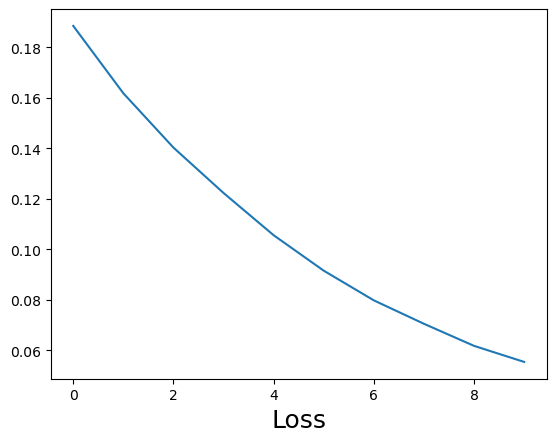

In [35]:
print(train_loss)
plt.plot(train_loss)
plt.xlabel('Epoch', size=18)

plt.xlabel('Loss', size=18)

plt.savefig('figures/wed_loss.png', dpi=200)


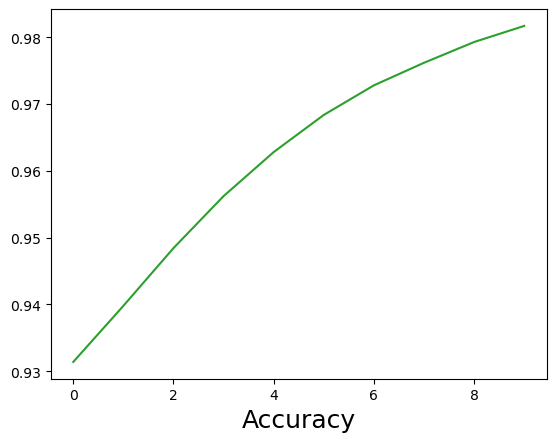

In [36]:
plt.plot(train_acc, color='tab:green')
plt.xlabel('Epoch', size=18)
plt.xlabel('Accuracy', size=18)
plt.savefig('figures/wed_accuracy.png', dpi=200)

In [ ]:
# model.save('model1')

In [ ]:
file_list[0]

'/Users/veraberger/nasa/training_data/267484897_47_2_data.npy'

In [89]:
file_list_pred

NameError: name 'file_list_pred' is not defined

 fluxes 1 labels 1 centroid 1 poscorr 1


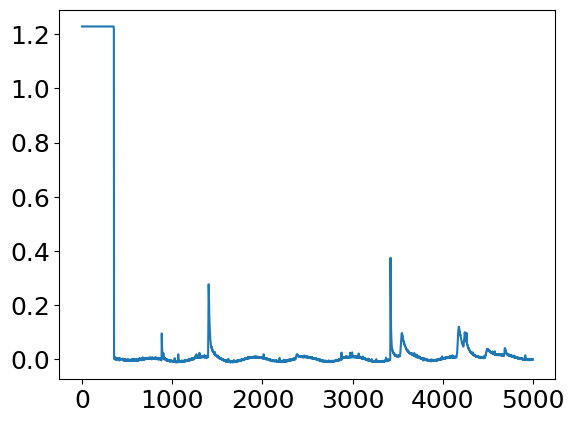

In [43]:
file_list_pred = file_list[12]
lcdata = np.load(file_list_pred).T
flux_list, label_list, centroid_list, poscorr_list, cr_list = prep_for_generator(lcdata, fname=None)

[sub_lc] =flux_list
[sub_centroid] = centroid_list
[sub_poscorr] = poscorr_list
[sub_cr] = cr_list
init_time = lcdata[0]

k = 5000
# take a k-sized section of the lc
sub_lc = sub_lc[:k]
sub_centroid = sub_centroid[:k]
sub_poscorr = sub_poscorr[:k]
sub_cr = sub_cr[:k]
plt.plot(sub_lc)

In [316]:
# # I haven't actually tested this
# score = model.evaluate([sub_lc, sub_centroid, sub_poscorr, sub_cr], verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [ ]:
# ntime = fill_time(init_time)
nflares = fill_gaps(init_time, ntime, flares, zeros=True)
nflares = pad(nflares)
nflares = nflares[:5500]

In [ ]:
plt.plot(sub_lc)
plt.show()

In [44]:
# !conda install ipywidgets --yes
# !conda install jupyter --yes

window_size=700
preds = np.zeros(len(sub_lc))
print(len(preds))
for i in range(len(sub_lc)-window_size):
# for i in tqdm(range(len(sub_lc)-window_size)):
    lc_slice = sub_lc[i:i+window_size]
    centroid_slice = sub_centroid[i:i+window_size]
    poscorr_slice = sub_poscorr[i:i+window_size]
    cr_slice = sub_cr[i:i+window_size]
    preds[i+int(window_size/2)] = model.predict([lc_slice.reshape(1,window_size,1), 
                                                 centroid_slice.reshape(1,window_size,1), 
                                                poscorr_slice.reshape(1,window_size,1), 
                                                cr_slice.reshape(1,window_size,1)], 
                                                verbose=0
                                               )

5000


In [ ]:


# sub_lc = lc_list[0][:15000]
# preds = np.zeros(len(sub_lc))
# for i in tqdm(range(len(sub_lc)-window_size)):
#   lc_slice = sub_lc[i:i+window_size]
#   #plt.scatter(lc_slice.time.value, lc_slice.flux.value, c = y[(idx+i-int(num_preds/2)-int(window_size/2)) : (idx+i-int(num_preds/2)+int(window_size/2))])
#   #plt.show()
#   preds[i+int(window_size/2)] = model.predict(lc_slice.reshape(1,window_size,1), verbose=0)


In [45]:
print(sum(preds), '* max pred', preds.max(), '* min pred', preds.min(), '* median pred', np.median(preds))

3270.755655685789 * max pred 1.0 * min pred 0.0 * median pred 0.8907025754451752


In [ ]:
model.save('monmodel.h5')

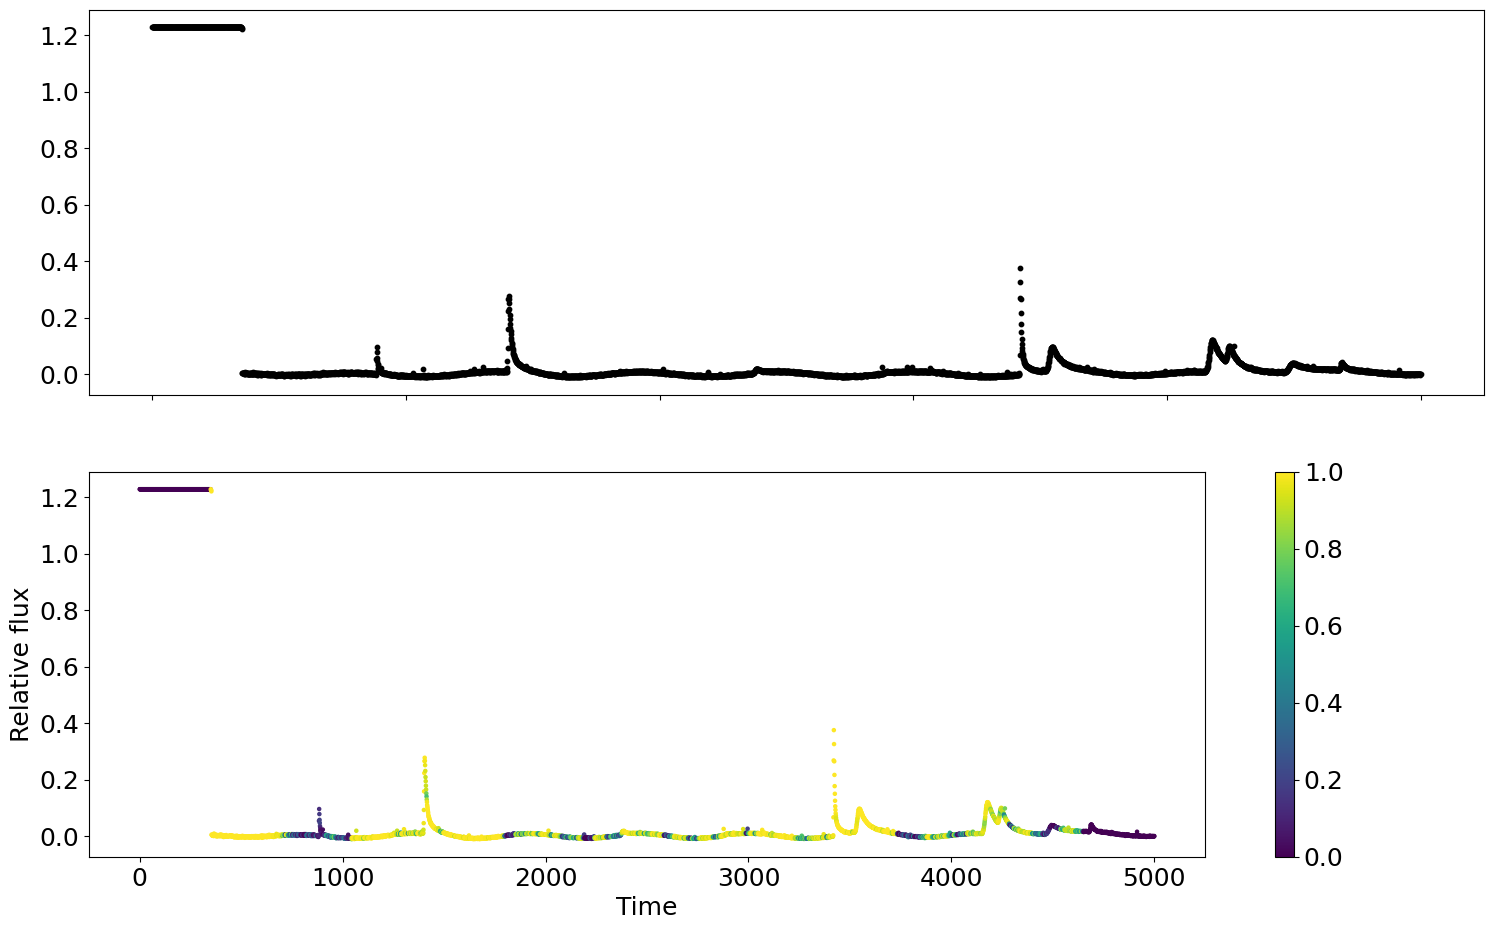

In [46]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
fig, ax = plt.subplots(2, figsize=(18,11), sharex=True, sharey=True)
ax[0].scatter(np.linspace(0, len(sub_lc), len(sub_lc)), sub_lc, c='black', s=10)
# ax[0].scatter(np.linspace(0, len(sub_lc), len(sub_lc)), sub_lc, c=nflares, cmap='viridis', s=10)
mappable = ax[1].scatter(np.linspace(0, (len(sub_lc)), len(sub_lc)), sub_lc, c=preds, cmap='viridis', s=5)
plt.colorbar(mappable)
# ax[0].set_ylim(-.03, 0.25)
# ax[0].set_xlim(500, 5350)
ax[1].set_ylabel("Relative flux", size=18)
ax[1].set_xlabel("Time", size=18)
# fig.tick_params(labelsize=18)
# ax[0].set_xlim(20000, 45000)
# plt.savefig('figures/first_pred_idk.png', dpi=200, bbox_inches='tight', transparent=False)
plt.show()